In [7]:
import numpy as np
import matplotlib.pyplot as plt

def step(u):
    return (u >= 0).astype(float)  # Heaviside con umbral en 0


In [8]:
W_hidden = np.array([
    [ 1.0,  0.0],   # x >= 0
    [-1.0,  0.0],   # x <= 2
    [ 0.0,  1.0],   # y >= 0
    [ 0.0, -1.0],   # y <= 2
    [ 1.0,  1.0],   # y >= -x
    [-1.0,  1.0],   # y >=  x - 2
], dtype=float)

b_hidden = np.array([
    0.0,   # x >= 0
    2.0,   # x <= 2
    0.0,   # y >= 0
    2.0,   # y <= 2
    0.0,   # y >= -x
    2.0,   # y >= x - 2
], dtype=float)

# ---- Capa de salida con 2 neuronas: AND y luego NOT (todo con escalón) ----
# AND: s = sum(h_i) - (m - 0.5) >= 0  <=> 1 sólo si TODAS las h_i=1
m = W_hidden.shape[0]
W_and  = np.ones((1, m))     # pesos de la neurona AND
b_and  = np.array([-(m - 0.5)])

# NOT: y = step( -AND + 0.5 )  -> 1 si AND=0, 0 si AND=1
W_not  = np.array([[-1.0]])  # toma la salida de AND
b_not  = np.array([0.5])

def mlp_step(X2):
    """
    X2: array (..., 2) con coordenadas (x,y)
    return: y_hat en {0,1} donde 0 = interior (círculos), 1 = exterior (estrellas)
    """
    H = step(X2 @ W_hidden.T + b_hidden)     # (n,6)
    AND_out = step(H @ W_and.T + b_and)      # (n,1)
    Y = step(AND_out @ W_not.T + b_not)      # (n,1)
    return Y.ravel(), H, AND_out.ravel()


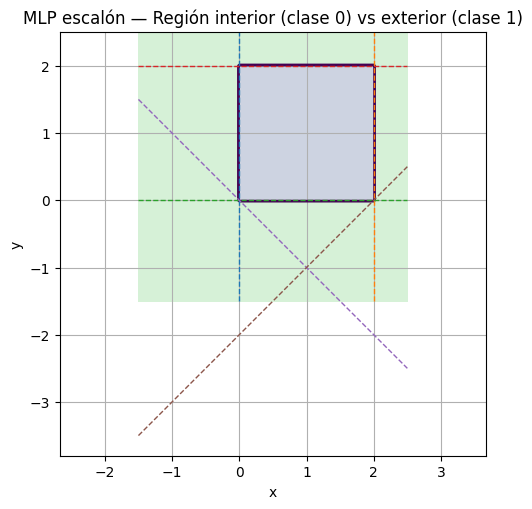

In [9]:
xs = np.linspace(-1.5, 2.5, 161)
ys = np.linspace(-1.5, 2.5, 161)
XX, YY = np.meshgrid(xs, ys)
grid = np.c_[XX.ravel(), YY.ravel()]
Z, _, _ = mlp_step(grid)
Z = Z.reshape(XX.shape)

plt.figure(figsize=(5.5,5.5))
plt.contourf(XX, YY, Z, levels=[-0.1,0.5,1.1], alpha=0.25)  # 0 = interior (clase 0), 1 = exterior (clase 1)
plt.contour(XX, YY, Z, levels=[0.5], linewidths=2)

# Dibuja las 6 rectas de frontera (opcional)
def draw_line(ax, a, b, xlim=(-1.5,2.5)):
    # a = (ax, ay), b = bias en ax*x + ay*y + b = 0
    xs = np.linspace(*xlim, 200)
    if abs(a[1]) < 1e-12:
        x0 = -b / a[0]
        ax.plot([x0, x0], [xlim[0], xlim[1]], '--', lw=1)
    else:
        ys = -(a[0]*xs + b)/a[1]
        ax.plot(xs, ys, '--', lw=1)

ax = plt.gca()
for (ax_w, ay_w), bb in zip(W_hidden, b_hidden):
    draw_line(ax, (ax_w, ay_w), bb)

plt.title("MLP escalón — Región interior (clase 0) vs exterior (clase 1)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal'); plt.grid(True); plt.show()


In [10]:
tests = np.array([
    [ 1.0,  1.0],  # dentro (esperado 0)
    [ 0.2,  0.2],  # dentro cerca de (0,0)
    [ 1.8,  0.3],  # dentro cerca del borde derecho y fondo en V
    [-0.5,  1.0],  # fuera a la izquierda
    [ 2.2,  1.0],  # fuera a la derecha
    [ 1.0,  2.2],  # fuera arriba
    [ 1.0, -0.8],  # fuera debajo de la V
], dtype=float)

y_hat, H, AND_out = mlp_step(tests)
for p, yh in zip(tests, y_hat):
    print(f"x={p[0]:>5.2f}, y={p[1]:>5.2f} -> pred={int(yh)}  ({'interior=0' if yh==0 else 'exterior=1'})")


x= 1.00, y= 1.00 -> pred=0  (interior=0)
x= 0.20, y= 0.20 -> pred=0  (interior=0)
x= 1.80, y= 0.30 -> pred=0  (interior=0)
x=-0.50, y= 1.00 -> pred=1  (exterior=1)
x= 2.20, y= 1.00 -> pred=1  (exterior=1)
x= 1.00, y= 2.20 -> pred=1  (exterior=1)
x= 1.00, y=-0.80 -> pred=1  (exterior=1)


In [11]:
import pandas as pd
import numpy as np

# Capa oculta: cada neurona = semiespacio a_x x + a_y y + b >= 0
df_hidden = pd.DataFrame(
    np.c_[W_hidden, b_hidden],
    columns=["w_x","w_y","bias"],
    index=[f"h{i+1}" for i in range(W_hidden.shape[0])]
)

# Capa de salida separada en dos tablas por tener distinta cantidad de entradas
# AND: depende de h1..h6
df_and = pd.DataFrame(
    np.c_[W_and, b_and],
    columns=[*(f"h{i+1}" for i in range(W_hidden.shape[0])), "bias"],
    index=["AND"]
)

# NOT: depende solo de la salida de AND
df_not = pd.DataFrame(
    np.c_[W_not, b_not],
    columns=["AND","bias"],
    index=["NOT"]
)

print("Capa oculta (semiespacios):")
display(df_hidden)

print("\nCapa de salida — neurona AND (toma h1..h6):")
display(df_and)

print("\nCapa de salida — neurona NOT (toma AND):")
display(df_not)

Capa oculta (semiespacios):


,w_x,w_y,bias
h1,1.0,0.0,0.0
h2,-1.0,0.0,2.0
h3,0.0,1.0,0.0
h4,0.0,-1.0,2.0
h5,1.0,1.0,0.0
h6,-1.0,1.0,2.0



Capa de salida — neurona AND (toma h1..h6):


,h1,h2,h3,h4,h5,h6,bias
AND,1.0,1.0,1.0,1.0,1.0,1.0,-5.5



Capa de salida — neurona NOT (toma AND):


,AND,bias
NOT,-1.0,0.5


# Red Neuronal Multicapa con Función Escalón

En este ejercicio se diseñó una **red neuronal multicapa superficial** compuesta por neuronas con **función de activación tipo escalón** con el objetivo de **separar los patrones mostrados en el plano** (círculos "0" en el interior y estrellas "1" en el exterior).

##  Estructura de la red

La red está formada por dos capas:

### Capa oculta
- **6 neuronas escalón**, cada una representando un **semiespacio lineal**
- Cada neurona aprende una desigualdad del tipo: $a_x x + a_y y + b \ge 0$
- Estas desigualdades definen las fronteras que delimitan la región interior (clase 0)

Las condiciones diseñadas son:
1. $x \ge 0$
2. $x \le 2$
3. $y \ge 0$
4. $y \le 2$
5. $y \ge -x$
6. $y \ge x - 2$

La intersección de estas seis condiciones genera la zona interior en forma de **rectángulo con borde inferior en "V"**, que coincide con el área ocupada por los círculos.

### Capa de salida
- Una neurona realiza un **AND** lógico sobre las salidas de las 6 neuronas ocultas, activándose solo cuando **todas las condiciones se cumplen simultáneamente** (es decir, cuando el punto está dentro de la región).
- Una neurona adicional aplica un **NOT** a la salida del AND, invirtiendo la lógica para mapear:
  - **Salida = 0:** punto dentro de la región (círculos)
  - **Salida = 1:** punto fuera de la región (estrellas)

##  Resultados y validación

- El modelo separa correctamente los patrones, clasificando como **clase 0** todos los puntos dentro de la región poligonal y como **clase 1** todos los puntos fuera de ella.
- Las pruebas puntuales confirman que puntos en el interior de la región son clasificados como `0`, mientras que puntos exteriores son clasificados como `1`.
- La visualización de la frontera muestra una separación nítida y coherente con la distribución del conjunto de datos.

##  Conclusión

Se logró implementar exitosamente una **red neuronal multicapa con función escalón** capaz de resolver un problema de clasificación **no linealmente separable** mediante la **combinación de múltiples hiperplanos lineales** en la capa oculta y operaciones lógicas en la capa de salida. Este enfoque demuestra cómo las redes multicapa permiten construir regiones de decisión complejas a partir de funciones de activación simples.